In [240]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [241]:
train = pd.read_csv('./training_set_features.csv', index_col='respondent_id')
labels1 = pd.read_csv('./training_set_labels.csv', index_col='respondent_id')['h1n1_vaccine']
labels2 = pd.read_csv('./training_set_labels.csv', index_col='respondent_id')['seasonal_vaccine']
test_features = pd.read_csv('./test_set_features.csv', index_col='respondent_id')


In [242]:
num_cols = train.select_dtypes('number').columns

cat_cols = ['race', 'sex',
            'marital_status', 'rent_or_own', 'hhs_geo_region',
            'census_msa', 'employment_industry', 'employment_occupation']

ord_cols = ['age_group', 'education', 'income_poverty',
            'employment_status']
# Impute train
for col in num_cols:
    train[col] = train[col].fillna(value=-1)
for col in (cat_cols + ord_cols):
    train[col] = train[col].fillna(value='missing')

# Impute test
for col in num_cols:
    test_features[col] = test_features[col].fillna(value=-1)
for col in (cat_cols + ord_cols):
    test_features[col] = test_features[col].fillna(value='missing')

In [243]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

objList = ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own',
           'employment_status', 'hhs_geo_region', 'census_msa', 'employment_industry', 'employment_occupation']
for feat in objList:
    train[feat] = le.fit_transform(train[feat].astype(str))
for feat in objList:
    test_features[feat] = le.fit_transform(test_features[feat].astype(str))


In [244]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train, labels1, test_size=0.2, random_state=42)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [245]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
}

In [246]:
from sklearn.metrics import accuracy_score
import xgboost as xgb
def objective(space):
        clf=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0,
                importance_type='gain', learning_rate=0.01, max_delta_step=0,
                max_depth=3, min_child_weight=1, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                silent=None, subsample=1, verbosity=1)

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, pred>0.5)
        print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }

In [247]:
from xgboost import cv

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.05,
                'max_depth': 5, 'alpha': 10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=10, metrics="auc", as_pandas=True, seed=123)

In [248]:
"""trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)"""

'trials = Trials()\n\nbest_hyperparams = fmin(fn = objective,\n                        space = space,\n                        algo = tpe.suggest,\n                        max_evals = 100,\n                        trials = trials)'

In [249]:
xgb_cv.head()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.738818,0.005602,0.736751,0.008563
1,0.774254,0.025174,0.773702,0.019505
2,0.806477,0.019749,0.805204,0.017412
3,0.822509,0.014939,0.819662,0.019691
4,0.821025,0.017909,0.817105,0.023116


In [250]:
#print(best_hyperparams)

In [251]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
xgr=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=0.5502213886729552, gamma=8.469419079759977,
        importance_type='gain', learning_rate=0.01, max_delta_step=0,
        max_depth=10, min_child_weight=6.0, n_estimators=100,
        n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
        reg_alpha=0, reg_lambda=0.27358178819421364, scale_pos_weight=1, seed=None,
        silent=None, subsample=1, verbosity=1)

evaluation = [train, labels1]

xgr.fit(train, labels1)

y_pred = xgr.predict(test_features)

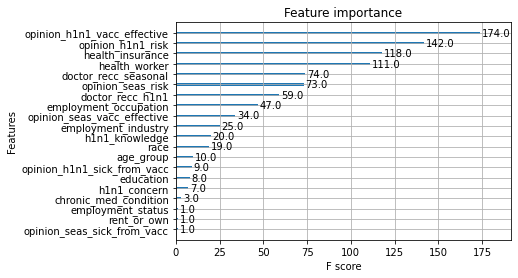

<Figure size 1152x864 with 0 Axes>

In [252]:
xgb.plot_importance(xgr)
plt.figure(figsize = (16, 12))
plt.show()

In [253]:
train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,2,1,0,1,8,2,0.0,0.0,9,10
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,2,1,1,0,1,0,0.0,0.0,13,20
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-1.0,...,0,1,0,0,9,0,2.0,0.0,15,22
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,2,1,1,1,5,1,0.0,0.0,9,10
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0,0,0,0,9,0,1.0,0.0,19,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,1,0,1,9,2,0.0,0.0,9,10
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0,1,1,0,6,1,1.0,0.0,4,2
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,3,1,0,3,6,0,0.0,0.0,9,10


In [254]:
y_pred.size

26708

In [255]:
"""
kfold = KFold(n_splits=10, random_state=10 ,shuffle=True)
result = cross_val_score(xgbr, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
print(result.mean())"""

"\nkfold = KFold(n_splits=10, random_state=10 ,shuffle=True)\nresult = cross_val_score(xgbr, X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)\nprint(result.mean())"

In [256]:
"""from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBClassifier
ypoints = []
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
# declare parameters
params = {
            'objective':'binary:logistic',
            'max_depth': 4,
            'alpha': 10,
            'learning_rate': 1.0,
            'n_estimators':100
        }         
           
          
# instantiate the classifier 
xgb_clf = XGBClassifier(**params)


# fit the classifier to the training data
xgb_clf.fit(X_train, y_train)
"""

"from sklearn.ensemble import RandomForestRegressor\nfrom sklearn.svm import SVR\nfrom xgboost import XGBClassifier\nypoints = []\ndata_dmatrix = xgb.DMatrix(data=X_train,label=y_train)\n# declare parameters\nparams = {\n            'objective':'binary:logistic',\n            'max_depth': 4,\n            'alpha': 10,\n            'learning_rate': 1.0,\n            'n_estimators':100\n        }         \n           \n          \n# instantiate the classifier \nxgb_clf = XGBClassifier(**params)\n\n\n# fit the classifier to the training data\nxgb_clf.fit(X_train, y_train)\n"

In [257]:
"""xgb_cv.head()"""

'xgb_cv.head()'

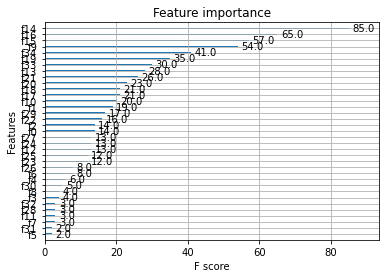

<Figure size 1152x864 with 0 Axes>

In [258]:
xgb.plot_importance(xgbr)
plt.figure(figsize = (16, 12))
plt.show()

In [259]:
from sklearn import metrics

# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
score = metrics.roc_auc_score(y_test, y_pred)
print(' Roc Auc Score:', score)

ValueError: Found input variables with inconsistent numbers of samples: [5342, 26708]

In [ ]:
"""# test_pred = regressor.predict(test_features)

# print(test_pred)
xpoints = np.arange(1, 101)

plt.plot(xpoints, ypoints)
plt.title("Curve plotted using the given points")
plt.xlabel("Number of Estimators")
plt.ylabel("Test Accuracies")
plt.show()"""


'# test_pred = regressor.predict(test_features)\n\n# print(test_pred)\nxpoints = np.arange(1, 101)\n\nplt.plot(xpoints, ypoints)\nplt.title("Curve plotted using the given points")\nplt.xlabel("Number of Estimators")\nplt.ylabel("Test Accuracies")\nplt.show()'

In [260]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(train, labels2, test_size=0.2, random_state=42)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train2 = sc.fit_transform(X_train2)
X_test2 = sc.transform(X_test2)

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
}

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
def objective(space):
        clf=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0,
                importance_type='gain', learning_rate=0.01, max_delta_step=0,
                max_depth=3, min_child_weight=1, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                silent=None, subsample=1, verbosity=1)

        evaluation = [( X_train2, y_train2), ( X_test2, y_test2)]

        clf.fit(X_train2, y_train2,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test2)
        accuracy = accuracy_score(y_test2, pred>0.5)
        print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.7626357169599401
SCORE:
0.762

In [ ]:
print(best_hyperparams)

{'colsample_bytree': 0.6063545543520819, 'gamma': 1.5160109364510506, 'max_depth': 12.0, 'min_child_weight': 8.0, 'reg_alpha': 176.0, 'reg_lambda': 0.4994303428476974}


In [261]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
xgr2=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=0.6063545543520819, gamma=1.5160109364510506,
        importance_type='gain', learning_rate=0.01, max_delta_step=0,
        max_depth=12, min_child_weight=8, n_estimators=100,
        n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
        reg_alpha=0, reg_lambda=0.4994303428476974, scale_pos_weight=1, seed=None,
        silent=None, subsample=1, verbosity=1)


xgr2.fit(train,labels2)

y_pred2 = xgr2.predict(test_features)

In [ ]:
from sklearn import metrics

# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
# print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
score = metrics.roc_auc_score(y_test2, y_pred2)
print(' Roc Auc Score:', score)

 Roc Auc Score: 0.8625547764901865


from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
def objective(space):
        clf=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0,
                importance_type='gain', learning_rate=0.01, max_delta_step=0,
                max_depth=3, min_child_weight=1, n_estimators=100,
                n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                silent=None, subsample=1, verbosity=1)

        evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X_train, y_train,
                eval_set=evaluation, eval_metric="auc",
                early_stopping_rounds=10,verbose=False)

        pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, pred>0.5)
        print ("SCORE:", accuracy)
        return {'loss': -accuracy, 'status': STATUS_OK }
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)
trials

roc_auc_score(y_test.h1n1_vaccine, predictions_h1)
print(best_hyperparams)
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
xgr=xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bynode=1, colsample_bytree=0.5502213886729552, gamma=8.469419079759977,
        importance_type='gain', learning_rate=0.01, max_delta_step=0,
        max_depth=10, min_child_weight=6.0, n_estimators=100,
        n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
        reg_alpha=0, reg_lambda=0.27358178819421364, scale_pos_weight=1, seed=None,
        silent=None, subsample=1, verbosity=1)

evaluation = [( X_train, y_train), ( X_test, y_test)]

xgr.fit(X_train, y_train,
        eval_set=evaluation, eval_metric="auc",
        early_stopping_rounds=10,verbose=False)

pred = xgr.predict(X_test)
accuracy = accuracy_score(y_test, pred>0.5)
print ("SCORE:", accuracy)
y_pred = xgr.predict(X_test)

In [262]:
submission_df = pd.read_csv("./submission_format.csv",
                            index_col="respondent_id")
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features.index.values,
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = y_pred
submission_df["seasonal_vaccine"] = y_pred2

print(submission_df.head())

df = pd.DataFrame(submission_df)

# saving the dataframe
df.to_csv('GFG.csv')

               h1n1_vaccine  seasonal_vaccine
respondent_id                                
26707              0.328149          0.359308
26708              0.218248          0.233983
26709              0.332434          0.626841
26710              0.454070          0.722683
26711              0.437312          0.522142
